<a href="https://colab.research.google.com/github/ag826/AIPI590_XAI_F25/blob/main/Assignment_Explainable_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - Explainable deep Learning
**Adil Keku Gazder**

**ag825@duke.edu**

**For AIPI 590 - XAI, Fall 2025**

**Duke University**




We work with a pretrained deep learning models to investigate model explainability in computer vision. Our objective is to apply GradCAM and at least two of its variants to a meaningful image classification problem of your choice and analyze how and why the model makes its decisions.

For this assignment, we choose to try and classify satellite images into different categories. We use the EuroSat dataset and the ResNet-50 model. We also do use GradCAM, GradCAM++ and ScoreCAM for the explainability aspect.

The accurate categorization of land use and land cover types from satellite imagery enables governments and organizations to make informed decisions regarding resource allocation, disaster response, climate change adaptation, and sustainable development. I chose this problem area to try and understand the magnitude of the problem being solved with these techniques and understand the 'behind-the-scenes' of its categorization capabilities.



In [ ]:
# Install the library for GradCAM
!pip install grad-cam

# Import necessary packages
import torch
from torchvision import models, transforms
from torchvision.datasets import EuroSAT
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# Import the CAM techniques
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=02ce3fea1b059eb5134ad8d91984137da7774a9ff9b81ee948bee16d47171aff
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
# Load a pretrained model (ResNet-50)
model = models.resnet50(pretrained=True)
model.eval() # Set the model to evaluation mode

# Define the target layer for ResNet-50's CAM
target_layers = [model.layer4[-1]]

# Define the image transformations required by ResNet-50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Download and load the EuroSAT dataset
eurosat_dataset = EuroSAT(root="data", download=True, transform=transform)
class_names = eurosat_dataset.classes
print("EuroSAT Classes:", class_names)

# Parts of this code were generated and debugged using Gemini 2.5 Pro at 1pm on Saturdat 10/04

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 94.7MB/s]
100%|██████████| 94.3M/94.3M [00:00<00:00, 162MB/s]


EuroSAT Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### **About the Dataset:**
The EuroSAT dataset is a widely used benchmark for land use and land cover classification using satellite imagery from the ESA Sentinel-2 satellite. It consists of 27,000 labeled and geo-referenced images, each measuring 64x64 pixels, and covers 13 spectral bands. The images in this dataset represent 10 different land use and land cover classes, such as agricultural, forest, residential, industrial, and more (exhaustive list printed in the code above).

### **About the Model:**
We use the ResNet-50 deep convolutional NN architecture which has 50 layers, generally used for image classification tasks. Its architecture involves 48 convolutional layers, along with 1 Maxpool and 1 Average pool layers, used to enable deep learning without the vanishing gradient problem. The last layer is marked as the target layer.

The inputs must be 224x224 pixels which is why the images are resized in the code above, after which they are normalized using the mean and SD from the ImageNet dataset.

100%|██████████| 128/128 [07:01<00:00,  3.29s/it]


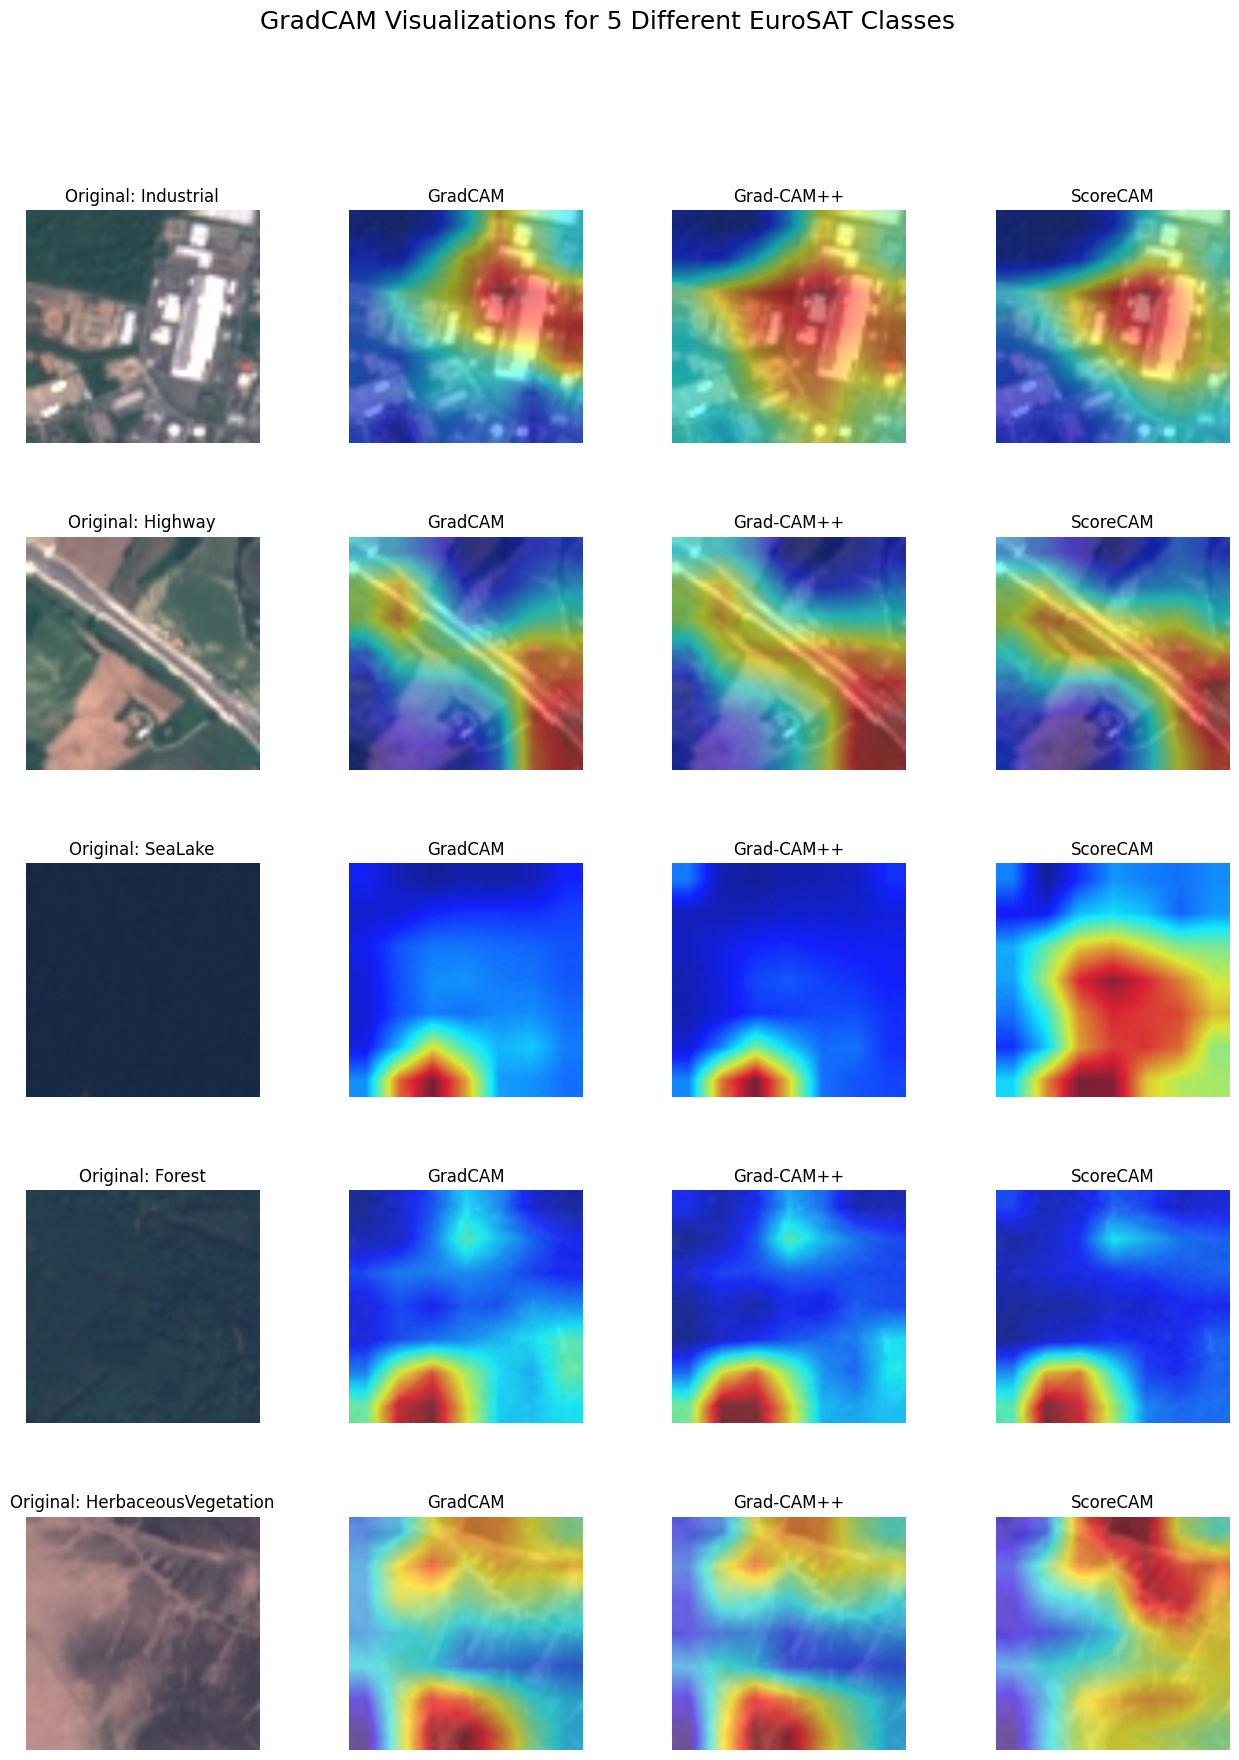

In [ ]:

# --- Helper function: un-normalize an image tensor for visualization ---
def un_normalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().detach().cpu().numpy().squeeze().transpose((1, 2, 0))
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

# --- Randomly select 5 different classes ---
unique_labels = list(set([label for _, label in eurosat_dataset]))
selected_labels = random.sample(unique_labels, 5)

# --- Initialize CAM methods once ---
cam_gradcam = GradCAM(model=model, target_layers=target_layers)
cam_gradcam_plusplus = GradCAMPlusPlus(model=model, target_layers=target_layers)
cam_scorecam = ScoreCAM(model=model, target_layers=target_layers)

# --- Set up plotting ---
fig, axs = plt.subplots(5, 4, figsize=(16, 20))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("GradCAM Visualizations for 5 Different EuroSAT Classes", fontsize=18)

# --- Loop over selected classes ---
for row, label in enumerate(selected_labels):
    # Find an image of this class
    class_name = class_names[label]
    class_indices = [i for i, (_, lbl) in enumerate(eurosat_dataset) if lbl == label]
    img, lbl = eurosat_dataset[class_indices[0]]  # Take the first image for simplicity

    # Prepare the input tensor
    input_tensor = img.unsqueeze(0)
    rgb_img = un_normalize(img)

    # Model prediction and target
    prediction_idx = model(input_tensor).argmax()
    targets = [ClassifierOutputTarget(prediction_idx)]

    # Generate grayscale CAMs
    grayscale_gradcam = cam_gradcam(input_tensor=input_tensor, targets=targets)[0, :]
    grayscale_gradcam_plusplus = cam_gradcam_plusplus(input_tensor=input_tensor, targets=targets)[0, :]
    grayscale_scorecam = cam_scorecam(input_tensor=input_tensor, targets=targets)[0, :]

    # Overlay heatmaps
    vis_gradcam = show_cam_on_image(rgb_img, grayscale_gradcam, use_rgb=True)
    vis_gradcam_plusplus = show_cam_on_image(rgb_img, grayscale_gradcam_plusplus, use_rgb=True)
    vis_scorecam = show_cam_on_image(rgb_img, grayscale_scorecam, use_rgb=True)

    # --- Plot results for this image ---
    axs[row, 0].imshow(rgb_img)
    axs[row, 0].set_title(f"Original: {class_name}")
    axs[row, 0].axis('off')

    axs[row, 1].imshow(vis_gradcam)
    axs[row, 1].set_title("GradCAM")
    axs[row, 1].axis('off')

    axs[row, 2].imshow(vis_gradcam_plusplus)
    axs[row, 2].set_title("Grad-CAM++")
    axs[row, 2].axis('off')

    axs[row, 3].imshow(vis_scorecam)
    axs[row, 3].set_title("ScoreCAM")
    axs[row, 3].axis('off')

plt.show()

# Parts of this code were generated and debugged using Gemini 2.5 Pro at 1pm on Saturdat 10/04

### **Explainability models:**

We choose to use 3 different explainability models to understand the logic used by the NN when classifying the image. We would want to generate heatmaps to see which part of the image input influences the NN's prediction for a specific class.

**GradCAM** - Uses the activations in the last convolutional layer to het the gradients of the target class score. It is computationally efficient and can be used widely, with its only disadvantage being that it may struggle with some of the finer details for complex images.

**GradCAM++** - Very similar to GradCAM but uses higher order derivatives of the activation maps to weigh the spatial features of the input. This is best used when we have multiple instances of the objects and overlapping regions but the computational requirements is slightly more than the regular GradCAM.

**ScoreCAM** - Instead of using gradients like GradCAM and GradCAM++ do, ScoreCAM tends to use the model's score response for the weighting mechanism. It uses pertubed versions of the input image amd sees the effect on the class score, with higher weights to features that produce larger increases in the target class confidence. It is very computationally expensive.

**Parts of this explaination have been refined using Perplexity at 3pm on Sunday 10/05*

### **Understanding our outputs:**

**For image 1 (Industrial Class):**  All 3 mostly focus on the cluster of building structures, with ScoreCAM having a sharper coverage and GradCAM++ having a more broader coverage compared to GradCAM.

**For image 2 (Highway Class):**  All 3 consistently focus on the stretch of the road as the main clue for the classification. Grad-CAM++ enhances the separation between the main path and the landscape. ScoreCAM yields a smooth, expansive highlight enveloping the road and nearby areas, indicating that the model integrates both the highway and its environment

**For image 3 (SeaLake Class):** The SeaLake image’s saliency maps from all three methods mostly focus on the lower part of the image. GradCAM and Grad-CAM++ tightly localize their attention to the lake itself, providing confidence that the model observes specific color and texture transitions in its decision process. ScoreCAM, while still prioritizing the main water body, disperses some focus across adjacent landscape, hinting that broader spatial context may help reinforce model certainty for aquatic categories.


**For image 4 (Forest Class):**  For the forest image, the core patch of dense green vegetation receives maximum emphasis in every saliency map, confirming the model’s use of color and vegetative texture cues for this class. GradCAM and Grad-CAM++ both localize their highlights to this central forested zone, with Grad-CAM++ offering marginally enhanced resolution at the boundaries. ScoreCAM, although capable of broader contextual attention in some cases, is still primarily emphasizing the region most responsible for the “forest” classification in this specific image.

**For image 5 (Herbaceous Vegetation Class):**  In the herbaceous vegetation image, the most textured regions are highlighted by all methods. GradCAM and Grad-CAM++ focus on the intricate surface features and distinctive linear markings, which the model leverages to recognize this class. The slightly greater spread and smoother transitions of ScoreCAM’s activation map suggest that the model also considers surrounding zones and broader landscape characteristics.

### **Overall Takeaways:**


- For most of our test images, the saliency maps show that the model tends to focus on the most relevant parts of the image, similar to what human intuition would dictate. For example looking at the 'industrial' and 'highway' classification, the model does focus on the cluster of buildings and the stretch of roads. This is seen across all 3 saliency maps (GradCAM, GradCAM++ and ScoreCAM) however a unique observation is that for the 'highway' classification, the model tends to focus more on a part of the highway (the bottom right corner) as compared to the entire stretch of road (core focus as highlighted in red).

- In almost all cases, both GradCAM and GradCAM++ tends to show very similar results, although GradCAM++ tends to have slightly well defined boundaries around regional features (highlighted in the 'Forest' and 'HerbaciousVegetation' categories).

- ScoreCAM tends to show more spatially scattered maps, compared to the rest ('Sealake' and 'HerbaciousVegetation' categories).

With all the 3 explainability methods used, we tend to see some similarities - the methods tend to focus more on the class-distinctive regions, but ScoreCAM tends to show us more smoother and spatially distributed maps, essentially taking into account more broader contextual features. The only trade off is the computational complexity involved with models like ScoreCAM and GradCAM++ as compared to GradCAM.

**Parts of this explaination have been refined using Perplexity at 9pm on Sunday 10/05*

### **Why should we care?**

Model explainability is crucial in satellite image classification for several reasons. First, decisions based on satellite imagery often have significant real-world consequences—impacting policy, resource distribution, disaster mitigation, and environmental stewardship. Stakeholders such as government agencies, scientists, and affected communities need to trust and understand how the model identifies and categorizes regions to ensure its outputs are valid, reliable, and ethically defensible. Explainability helps uncover whether the model focuses on genuinely meaningful parts of the image (e.g., land cover patterns) rather than spurious biases, reducing risks associated with unintelligible predictions. Additionally, having transparent insights into model decision processes supports continuous improvement, helps diagnose errors, aids model debugging, and fosters broader acceptance of AI solutions. Ultimately, explainable models promote accountability, trust, and effectiveness in critical societal applications like satellite-based land use classification.

**Parts of this explaination have been refined using Perplexity at 3pm on Sunday 10/05*